# Notebook Projet Chest X-Ray Pneumonia - Partie 1 (Réseau CNN pour la prédiction à 2 classes)

In [1]:
# Importation des librairies 
import numpy as np 
import pandas as pd 
import os 
import glob # pour récupérer les images dans les répertoires
%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from skimage import io, transform, color # pour la lecture et le préprocessing des images
from tensorflow.keras.preprocessing.image import ImageDataGenerator # pour réaliser l'étape de data augmentation 
import seaborn as sns # pour ploter les performances du modèles 
#import PIL
#import PIL.Image
from sklearn.metrics import confusion_matrix 

In [2]:
import tensorflow as tf # pour la création du CNN 
from tensorflow import keras # pour la création du CNN 
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [3]:
# Pour importer les données à partir du drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Récupération des images 
# Le chemin du répertoire "chest_xray", contenant les sous-répertoires "train" et "test".
main_path = "/content/drive/MyDrive/archive/chest_xray/"

train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

# Stockage des chemins des images d'apprentissage et test dans deux listes individuels. 
train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [10]:
# Création d'une liste qui contient le chemin des images d'apprentissage des classes "NORMAL" et "PNEUMONIA". 
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

# Création d'un dataframe qui contient pour chaque chemin dans la "train_list", la classe de l'image correspondante 
df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

In [9]:
# Création d'une liste qui contient le chemin des images de test des classes "NORMAL" et "PNEUMONIA". 
test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

# Création d'un dataframe qui contient pour chaque chemin contenu dans "test_list", la classe de l'image correspondante 
df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [ ]:
### (A ne lancer qu'une seule unique fois) 
# Transformer les images d'apprentissage et les stocker dans un array. 
IMG_SIZE = 224
train_array = np.empty((len(train_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
for i, img_path in enumerate(train_list):
    img = plt.imread(img_path) # lecture des images
    img = color.rgb2gray(img)  # conversion des images en niveau de gris
    # redimension des images, canaux = 1 pour image en niveau de gris
    img = transform.resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True) 
    train_array[i] = img # stockage des images dans un array

# Sauvegarder les vecteurs d'image et des labels sous format .npz
x_train = train_array
y_train = np.concatenate(([int(0)]*len(train_normal), [int(1)]*len(train_pneumonia)))
print(len(y_train))
np.savez("train_array_gray", x_train = x_train, y_train = y_train)

In [11]:
### (A ne lancer qu'une seule unique fois) 
# Transformer les images test et les stocker dans un array.
IMG_SIZE = 224
test_array = np.empty((len(test_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
for i, img_path in enumerate(test_list):
    img = plt.imread(img_path) # lecture des images
    img = color.rgb2gray(img) # conversion des images en niveau de gris
    # redimension des images, canaux = 1 pour image en biveau de gris
    img = transform.resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    test_array[i] = img # stockage des images dans un array

# Sauvegarder les vecteurs d'image et des labels sous format .npz
x_test = test_array
y_test = np.concatenate(([int(0)]*len(test_normal), [int(1)]*len(test_pneumonia)))
np.savez_compressed("test_array_gray", x_test = x_test, y_test = y_test)

In [ ]:
# Importation des array npz. nouvellement créées
train_gray = np.load("/content/drive/MyDrive/train_array_gray.npz")
test_gray = np.load("/content/drive/MyDrive/test_array_gray.npz")

In [12]:
# Création des variables d'apprentissage et test 
print(train_gray.files)
print(test_gray.files)
train_x = train_gray["x_train"]
train_y = train_gray["y_train"]

x_test = test_gray["x_test"]
y_test = test_gray["y_test"]

y_true = y_test

NameError: ignored

In [ ]:
df_train = df_train.sample(frac=1)
df_test = df_test.sample(frac=1)

In [ ]:
# Création du jeu de validation à partir du jeu d'apprentissage 
num_classes = 2
val_df = df_train.groupby("class").sample(n=int(0.2*len(df_train)/num_classes))
train_df = df_train.drop(val_df.index)

In [ ]:
# Création des variables d'apprentissage et test, après division du jeu train 
x_train = train_x[train_df.index]
y_train = train_y[train_df.index]
x_val = train_x[val_df.index]
y_val = train_y[val_df.index]

print(len(x_train))
print(len(x_val))

In [ ]:
x_train=x_train/255
x_test=x_test/255
x_val=x_val/255

In [ ]:
# Initilisation des poids sur les données selon la formule : nb total d'observation/2*nombre d'une classe 
count_train = train_df.groupby("class").count()
count_normal = count_train["image"]["Normal"]
count_pneumonia = count_train["image"]["Pneumonia"]
wnormal = len(train_df)/(2*count_normal)
wpneumonia = len(train_df)/(2*count_pneumonia)

class_weight = {0: wnormal,
                1: wpneumonia}
                

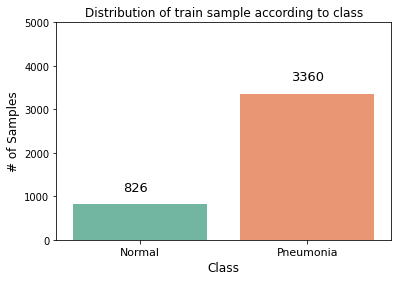

In [ ]:
# Distribution des classes "Normal" et "Pneumonia" dans train_df (jeu train)
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=train_df, palette="Set2") 

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal','Pneumonia'], fontsize = 11)
plt.title("Distribution of train sample according to class")

# Le nombre d'échantillon de chaque classes, ajouté au graphique
for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

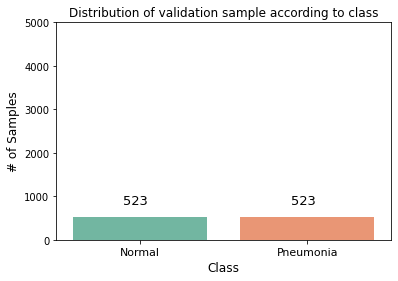

In [ ]:
# Distribution des classes "Normal" et "Pneumonia" dans val_df (jeu validation)
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=val_df, palette="Set2") 

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)
plt.title("Distribution of validation sample according to class")

# Le nombre d'échantillon de chaque classes, ajouté au graphique
for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

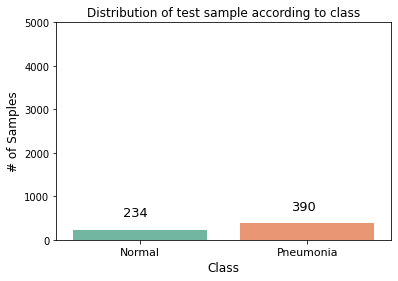

In [ ]:
# Distribution des classes "Normal" et "Pneumonia" dans df_test (jeu test)
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_test, palette="Set2") 

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)
plt.title("Distribution of test sample according to class")

# Le nombre d'échantillon de chaque classes, ajouté au graphique
for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)    
plt.show()

In [ ]:
IMG_SIZE = 224
BATCH = 32
SEED = 29

# Application de la data augmentation sur les données 
train_datagen = ImageDataGenerator(rescale=1/255.,
rotation_range=5,                            
width_shift_range=0.1,
height_shift_range=0.1,
zoom_range=0.05,
fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1/255.)


ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             color_mode = "grayscale",
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'categorical',
                                             batch_size = BATCH,
                                             seed = SEED)
train_datagen.fit(x_train, seed = SEED)


Found 4186 validated image filenames belonging to 2 classes.


(224, 224, 1)


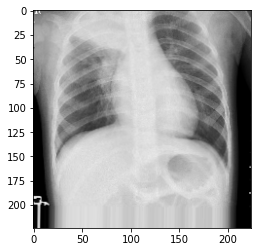

(224, 224, 1)


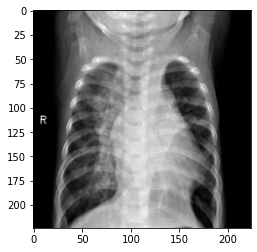

(224, 224, 1)


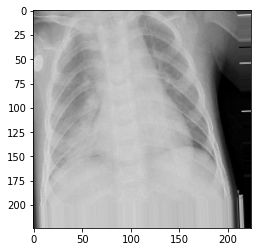

(224, 224, 1)


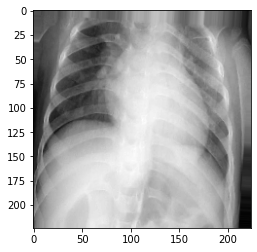

(224, 224, 1)


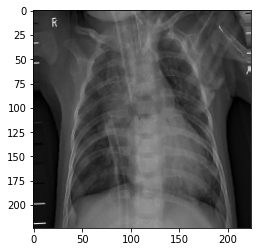

In [ ]:
# Visualisation des 5 premières images après data augmentation 
for i in range(5):
    img, label = next(ds_train)
    print(img[0].shape)  
    plt.imshow(tf.squeeze(img[0]), cmap='gray')
    plt.show()

In [ ]:
def plot_graph(history): 
  # Les courbes loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model_loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc ='upper left')
  plt.show()

  # Les courbes d'accuracy
  plt.plot(history.history['binary_accuracy'])
  plt.plot(history.history['val_binary_accuracy'])
  plt.title('model_accuracy')
  plt.ylabel('binary accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc ='upper left')
  plt.show()


In [ ]:
def get_performance(model): 
  test_loss, test_acc = model.evaluate(x_test, y_test, steps = len(train_df), verbose = 0)
  print("Test loss : %6.4f" %(test_loss))
  print("Test accuracy : %5.2f " %(test_acc))
  val_loss, val_acc = model.evaluate(x_val, y_val, steps = len(val_df), verbose = 0)
  print("Val loss : %6.4f " %(val_loss))
  print("Val accuracy :  %5.2f " %(val_acc))

Nous construisons un modèle simple pour pouvoir tester les différents hyperparamètres (learning-rate, batch-size..) et déterminer celles qui minimiseront la valeur de la loss. 
Le modèle simple 1, composé d'une couche de convolution à 8 filtres (kernel_size = 4\*4), suivie d'un MaxPooling, d'une BatchNormalisation, d'un Flatten et d'une couche de sortie. 

### Modèle simple


In [ ]:
# Modèle simple 1 
IMG_SIZE = 224
BATCH = 32
def get_model_simple1(): 
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1)) # couche d'entrée
    x = layers.Conv2D(filters=16, kernel_size=4, padding='valid', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Flatten()(x)
    #x = layers.Dense(8, activation='relu')(x)
    x = layers.BatchNormalization()(x) 
    output = layers.Dense(1, activation='sigmoid')(x) # couche de sortie

    model = keras.Model(inputs=[inputs], outputs=output)    
    return model

In [ ]:
# Compilation du modèle simple 1, learning rate à 0.1
keras.backend.clear_session()

model = get_model_simple1()

model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.1), metrics='binary_accuracy')
model.summary()
history = model.fit(x_train, y_train, batch_size = BATCH, epochs = 10, validation_data = (x_val, y_val)) 
plot_graph(history)
get_performance(model)

In [ ]:
# Variation du taux d'apprentissage, learning rate à 0.00001
keras.backend.clear_session()

model = get_model_simple1()

model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.00001), metrics='binary_accuracy')
model.summary()

# Apprentissage du model 
history = model.fit(x_train, y_train, batch_size = BATCH, epochs = 10, validation_data = (x_val, y_val)) 
plot_graph(history)
get_performance(model)

In [ ]:
# Variation du batch-size, défini à 16
BATCH = 16
keras.backend.clear_session()

model = get_model_simple1()

model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.000028), metrics='binary_accuracy')
model.summary()

# Apprentissage du model, sans data augmentation
history = model.fit(x_train, y_train, batch_size = BATCH, epochs = 10, validation_data = (x_val, y_val)) 
plot_graph(history)
get_performance(model)

In [ ]:
# Variation du batch-size, défini à 64
BATCH = 64
keras.backend.clear_session()

model = get_model_simple1()

model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.000028), metrics='binary_accuracy')
model.summary()

# Apprentissage du model, sans data augmentation
history = model.fit(x_train, y_train, batch_size = BATCH, epochs = 10, validation_data = (x_val, y_val)) 
plot_graph(history)
get_performance(model)

In [ ]:
# Application du poids sur les données 
BATCH = 32
keras.backend.clear_session()

model = get_model_simple1()

model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.000028), metrics='binary_accuracy')
model.summary()
# L'apprentissage du modèle, sans data augmentation
history = model.fit(x_train, y_train, batch_size = BATCH, epochs = 10, validation_data = (x_val, y_val), class_weight = class_weight) 
plot_graph(history)
get_performance(model)

Après avoir défini les choix des hyperparamètres, nous augmentons le nombre de couche de convolution. Le modèle intermédiaire 1 est composé de deux blocs répétés (1 bloc : une couche de convolution, suivie d'un MaxPooling, d'une BatchNormalisation). La première couche de convolution est constitué de 8 filtres, la seconde de 16 filtres avec kernel_size = 4\*4. Enfin, une dernière couche dense à 8 filtres précède la couche de sortie.

### Modèle intermédiaire

In [ ]:
# Modèle intermédiaire 1, avec deux couches de convolution
IMG_SIZE = 224
BATCH = 32
def get_model_inter1(): 
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Conv2D(filters=8, kernel_size=4, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(filters=16, kernel_size=4, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(8, activation='relu')(x)
    x = layers.BatchNormalization()(x) 

    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 221, 221, 8)       136       
_________________________________________________________________
batch_normalization (BatchNo (None, 221, 221, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 107, 16)      2064      
_________________________________________________________________
batch_normalization_1 (Batch (None, 107, 107, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 16)        0     

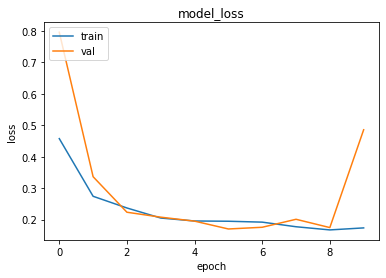

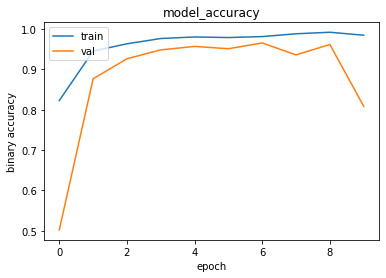

Test loss : 0.4551
Test accuracy :  0.80 
Val loss : 0.4858 
Val accuracy :   0.81 


In [ ]:
# Compilation du modèle intermédiaire 1, sans data augmentation
keras.backend.clear_session()
model = get_model_inter1()

model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.000028), metrics='binary_accuracy')
model.summary()

# Apprentissage du modèle, sans data augmentation
history = model.fit(x_train, y_train, batch_size = BATCH, epochs = 10, validation_data = (x_val, y_val)) 
plot_graph(history)
get_performance(model)

In [ ]:
# Modèle intermédiaire 2, avec deux couches de convolution et deux couches dense 
IMG_SIZE = 224
BATCH = 32
def get_model_inter2(): 
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Conv2D(filters=16, kernel_size=4, padding='valid', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    #x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(filters=32, kernel_size=4, padding='valid', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)
    #x = layers.Dropout(0.3)(x)


    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.BatchNormalization()(x) 
    x = layers.Dense(8, activation='relu')(x)
    x = layers.BatchNormalization()(x) 

    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[inputs], outputs=output)    
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 221, 221, 16)      272       
_________________________________________________________________
batch_normalization (BatchNo (None, 221, 221, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 107, 32)      8224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 107, 107, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 32)        0     

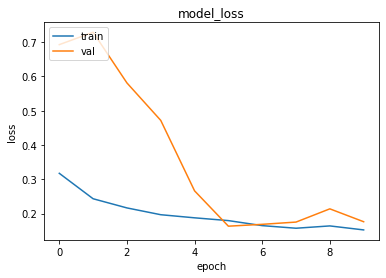

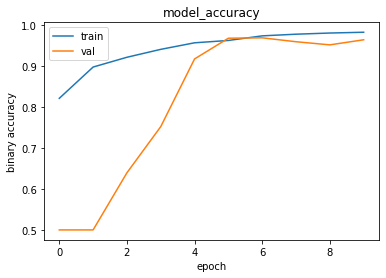

Test loss : 0.3486
Test accuracy :  0.85 
Val loss : 0.1764 
Val accuracy :   0.96 


In [ ]:
# Compilation du modèle intermédiaire 2, sans data augmentation
keras.backend.clear_session()

model = get_model_inter2()

model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.000028), metrics='binary_accuracy')
model.summary()

# Apprentissage du modèle, sans data augmentation
history = model.fit(x_train, y_train, batch_size = BATCH, epochs = 10, validation_data = (x_val, y_val), class_weight = class_weight) 
plot_graph(history)
get_performance(model)

### Modèle plus complexe

In [ ]:
# Modèle complexe 1
IMG_SIZE = 224
BATCH = 32
def get_model_complex1(): 
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Conv2D(filters=8, kernel_size=4, padding='valid')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(filters=16, kernel_size=4, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(filters=32, kernel_size=4, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(8, activation='relu')(x)
    x = layers.BatchNormalization()(x) 

    output = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 221, 221, 8)       136       
_________________________________________________________________
batch_normalization (BatchNo (None, 221, 221, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 107, 16)      2064      
_________________________________________________________________
batch_normalization_1 (Batch (None, 107, 107, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 16)        0     

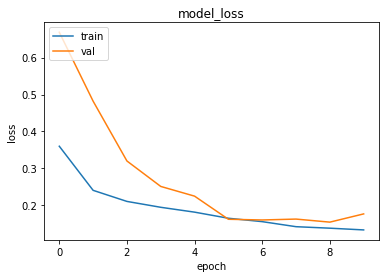

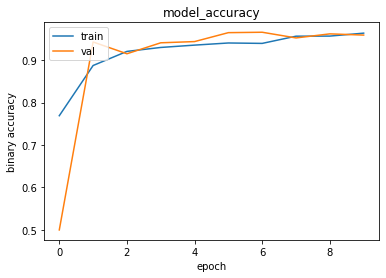

Test loss : 0.3271
Test accuracy :  0.88 
Val loss : 0.1771 
Val accuracy :   0.96 


In [ ]:
# Compilation du modèle complexe 1, sans data augmentation
keras.backend.clear_session()

model = get_model_complex1()

model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.000028), metrics='binary_accuracy')
model.summary()

# L'apprentissage du modèle, sans data augmentation
history = model.fit(x_train, y_train, batch_size = BATCH, epochs = 10, validation_data = (x_val, y_val), class_weight = class_weight) 
plot_graph(history) 
get_performance(model)

### 'Meilleur' modèle

In [ ]:
# Meilleur modèle 
IMG_SIZE = 224
BATCH = 32
def get_model_inter3(): 
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Conv2D(filters=16, kernel_size=4, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    #x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    #x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(filters=32, kernel_size=4, padding='same')(x)
    x = layers.BatchNormalization()(x)
    #x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(8, activation='relu')(x)
    x = layers.Dropout(0.1)(x)

    output = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

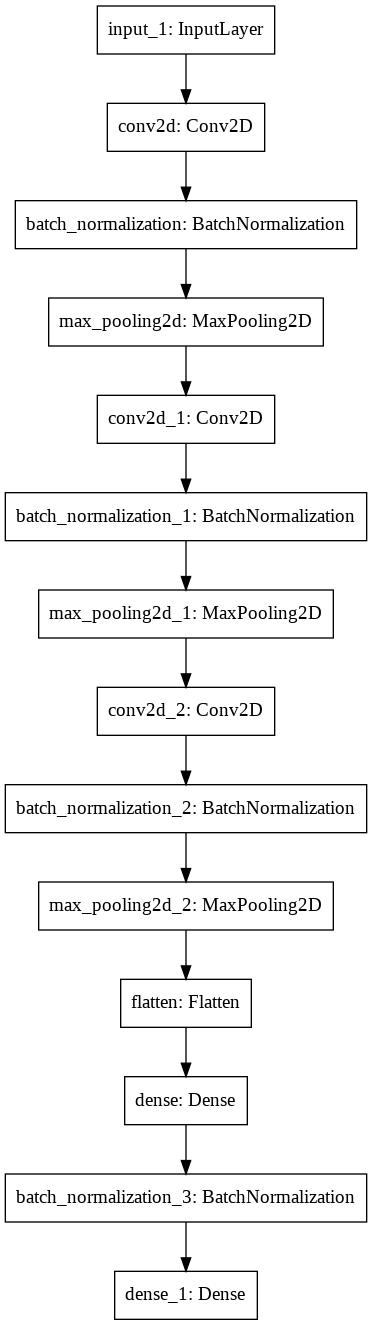

In [ ]:
# Structure du "meilleur" réseau
keras.utils.plot_model(model, "best_model.jpeg")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      272       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      8224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0     

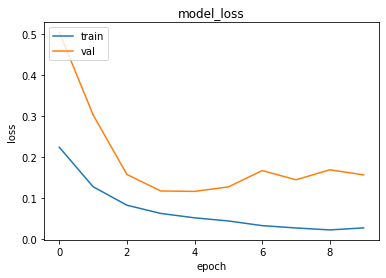

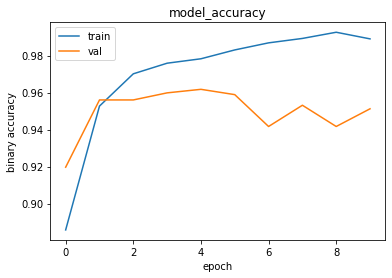

Test loss : 0.7623
Test accuracy :  0.82 
Val loss : 0.1572 
Val accuracy :   0.95 


In [ ]:
# Compilation du "meilleur" modèle, sans data augmentation
keras.backend.clear_session()

model = get_model_inter3()

model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.000028), metrics='binary_accuracy')
model.summary()
# L'apprentissage du modèle, sans data augmentation
history = model.fit(x_train, y_train, batch_size = BATCH, epochs = 10, validation_data = (x_val, y_val), class_weight = class_weight) 
plot_graph(history)
get_performance(model)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      272       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      8224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0     

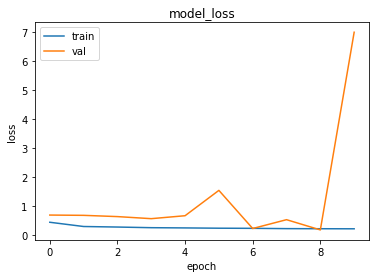

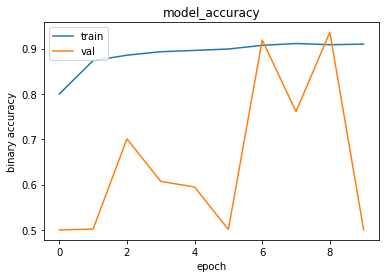

Test loss : 55.3112
Test accuracy :  0.84 
Val loss : 18.3711 
Val accuracy :   0.93 
Epoch 1/10
131/131 [==============================] - 24s 180ms/step - loss: 0.2083 - binary_accuracy: 0.9197 - val_loss: 3.2763 - val_binary_accuracy: 0.5000
Epoch 2/10
131/131 [==============================] - 24s 180ms/step - loss: 0.2166 - binary_accuracy: 0.9064 - val_loss: 2.9652 - val_binary_accuracy: 0.5029
Epoch 3/10
131/131 [==============================] - 23s 179ms/step - loss: 0.1989 - binary_accuracy: 0.9195 - val_loss: 3.6928 - val_binary_accuracy: 0.5000
Epoch 4/10
131/131 [==============================] - 23s 178ms/step - loss: 0.1908 - binary_accuracy: 0.9193 - val_loss: 2.6513 - val_binary_accuracy: 0.5076
Epoch 5/10
131/131 [==============================] - 23s 176ms/step - loss: 0.1823 - binary_accuracy: 0.9259 - val_loss: 3.8715 - val_binary_accuracy: 0.5000
Epoch 6/10
131/131 [==============================] - 23s 178ms/step - loss: 0.1945 - binary_accuracy: 0.9219 - val_los

In [ ]:
# Compilation du "meilleur" modèle, avec data augmentation
keras.backend.clear_session()

model = get_model_inter3()

model.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=0.000028), metrics='binary_accuracy')
model.summary()
# L'apprentissage du modèle, sans data augmentation
history = model.fit(train_datagen.flow(x_train, y_train), batch_size = BATCH, epochs = 10, validation_data = train_datagen.flow(x_val, y_val),  class_weight = class_weight) 
plot_graph(history)
get_performance(model)
history = model.fit(train_datagen.flow(x_train, y_train), batch_size = BATCH, epochs = 10, validation_data = train_datagen.flow(x_val, y_val),  class_weight = class_weight) 

In [ ]:
# Prédiction du 'meilleur' modèle sur le jeu de données test
predictions = model.predict(x_test)
print(predictions)
y_pred = np.argmax(predictions, axis = 1)
print(y_pred)
# Matrice de confusion
confusion_matrix = confusion_matrix(y_true, y_pred,  labels=[0,1])
sns.heatmap(confusion_matrix, annot = True)
plt.show()